# Cleaning of the Brighten Dataset
Access on Synapse.org

In [10]:
############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import importlib

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path for script usage
sys.path.append(project_root)

# Import and reload (optional) custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
importlib.reload(pre)
importlib.reload(vis)

################ DEFINE column variables from data ###################
from scripts.variables import id_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols


 
# ############ LOAD in raw files  #############
raw_dfs = {}
raw_dfs['phq9'] = pd.read_csv(os.path.join(brighten_dir,'PHQ-9 - Depression.csv'))
raw_dfs['phq2'] = pd.read_csv(os.path.join(brighten_dir,'PHQ-2 - Depression.csv'))
raw_dfs['alc'] = pd.read_csv(os.path.join(brighten_dir,'Alcohol.csv'))
raw_dfs['gad'] = pd.read_csv(os.path.join(brighten_dir,'GAD - Anxiety.csv'))
raw_dfs['fi'] = pd.read_csv(os.path.join(brighten_dir,'SDS - Functional Impairment.csv'))
raw_dfs['sleep'] = pd.read_csv(os.path.join(brighten_dir,'Sleep Quality.csv'))
raw_dfs['gic'] = pd.read_csv(os.path.join(brighten_dir,'Patients Global Impression of Change Scale.csv'))
raw_dfs['mhs'] = pd.read_csv(os.path.join(brighten_dir,'Mental Health Services.csv'))
raw_dfs['phone_v1'] = pd.read_csv(os.path.join(brighten_dir,'Passive Phone Features Brighten V1.csv'))
raw_dfs['phone_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Phone Communication Features Brighten V2.csv'))
raw_dfs['weather_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Weather Features Brighten V2.csv'))
raw_dfs['mobility_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Mobility Features Brighten V2.csv'))
raw_dfs['cluster_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Cluster Entries Brighten V2.csv'))
raw_dfs['phq9_baseline'] = pd.read_csv(os.path.join(brighten_dir,'PHQ-9 - Baseline.csv'))
raw_dfs['demo_df_clean'] = pd.read_csv(os.path.join(brighten_dir,'demo_df_clean.csv'))
raw_dfs['mania'] = pd.read_csv(os.path.join(brighten_dir,'IMPACT Mania and Psychosis Screening.csv'))




In [2]:
######### CLEANING AND UPDATING DATA ! #####################

# Update column names
for name, df in raw_dfs.items():
    print(name)
    if 'phq9Date' in df.columns:
        df['dt'] = (pd.to_datetime(df['phq9Date'])).dt.tz_localize(None)
        df = df.drop(['phq9Date','ROW_ID','ROW_VERSION'], axis=1)
    if 'dt_response' in df.columns:
        df['dt'] = (pd.to_datetime(df['dt_response'])).dt.tz_localize(None)
        df = df.drop(['dt_response','ROW_ID','ROW_VERSION'], axis=1)
    if 'dt_passive' in df.columns:
        df['dt'] = (pd.to_datetime(df['dt_passive'])).dt.tz_localize(None)
        df = df.drop(['dt_passive','ROW_ID','ROW_VERSION'], axis=1)
    if 'time_in' in df.columns:
         df['dt'] = (pd.to_datetime(df['time_in'])).dt.tz_localize(None)
         df = df.drop(['time_in','time_out', 'ROW_ID','ROW_VERSION'], axis=1)
    if 'baselinePHQ9date' in df.columns:
        df['dt'] = (pd.to_datetime(df['baselinePHQ9date'])).dt.tz_localize(None)
        df = df.drop(['baselinePHQ9date', 'ROW_ID','ROW_VERSION'], axis=1)
    if 'study' in df.columns: # drop because duplicated across tables
        df = df.drop(['study'], axis=1)
    if 'cohort' in df.columns: # drop because duplicated across tables 
        df = df.drop(['cohort'], axis=1)
    if 'day' in df.columns: # drop because not consistent in all tables and can be recreated after merging
        df = df.drop(['day'], axis=1)
    if 'startdate' in df.columns:
        df['dt'] = pd.to_datetime(df['startdate'], errors='coerce').dt.tz_localize(None)
    if 'baselinePHQ9date' not in name and 'demographics' not in name:
        if 'week' not in df.columns and name != 'demo_df_clean':
            print(f'assigning week numbers to {name}')
            df = pre.assign_week_numbers(df)
    if 'sum_phq9' in df.columns:
        df.rename(columns={'sum_phq9': 'phq9_sum'}, inplace=True)
    else:
        if 'week' not in df.columns:
            df['week'] = 0
        

    # Update the dfs dictionary with the modified DataFrame
    raw_dfs[name] = df


#### create binary and category variables
raw_dfs['alc']['alc_cat'] = raw_dfs['alc']['alc_sum'].apply(pre.cat_alc)
raw_dfs['gad']['gad_cat'] = raw_dfs['gad']['gad7_sum'].apply(pre.cat_gad)
raw_dfs['phq9']['phq9_cat'] = raw_dfs['phq9']['phq9_sum'].apply(pre.cat_phq9)
raw_dfs['phq9']['phq9_bin'] = raw_dfs['phq9']['phq9_sum'].apply(pre.bin_phq9)
raw_dfs['phq2']['phq2_bin'] = raw_dfs['phq2']['phq2_sum'].apply(pre.bin_phq2)


phq9
phq2
alc
gad
fi
sleep
gic
mhs
phone_v1
phone_v2
weather_v2
assigning week numbers to weather_v2
mobility_v2
cluster_v2
phq9_baseline
assigning week numbers to phq9_baseline


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_5534/3029908728.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['dt'] = (pd.to_datetime(df['baselinePHQ9date'])).dt.tz_localize(None)


demo_df_clean
mania


In [ ]:
### Create merge df 
merge_df = pd.DataFrame()

for name, df in raw_dfs.items():
    # Check if both 'num_id' and 'dt' exist in the current df
    if 'num_id' in df.columns and 'dt' in df.columns and 'week' in df.columns and name!='demo_df_clean':
        if merge_df.empty:
            merge_df = df  # Start with the first valid DataFrame
            print(f'Merged in {name}')
        else:
            merge_df = pd.merge(merge_df, df, on=['num_id', 'dt','week'], how='outer')
            print(f'Merged in {name}')
    
    else:
        print(f"Skipping {name}, 'num_id' or 'dt' or 'week' column is missing.")


# Save merge_df to csv
merge_df['dt'] = pd.to_datetime(merge_df['dt'], errors='coerce')
merge_df = merge_df.sort_values(by=['num_id', 'dt'])
merge_df.to_csv(os.path.join(brighten_dir, 'raw_merged_df.csv'), index=False)
print('Saved merge_df to raw_merged_df.csv')




Merged in phq9
Merged in phq2
Merged in alc
Merged in gad
Merged in fi
Merged in sleep
Merged in gic
Merged in mhs
Merged in phone_v1
Merged in phone_v2
Merged in weather_v2
Merged in mobility_v2
Merged in cluster_v2
Merged in phq9_baseline
Skipping demo_df_clean, 'participant_id' or 'dt' or 'week' column is missing.
Merged in mania
Saved merge_df to raw_merged_df.csv


In [ ]:
########## Combine rows from the same day ###############
days_df = pre.combine_same_day(merge_df)
days_df.to_csv(os.path.join(brighten_dir, 'days_df.csv'), index=False)
print('Saved final filled dataframe to days_df.csv')


############ Reindex to df_alldays ##########
#  days_df -> _alldays, reindexing each range of dates for a participant to include all dates in that range
df_alldays = pre.reindex_to_all_days(days_df)
df_alldays.to_csv(os.path.join(brighten_dir, 'df_alldays.csv'), index=False)

############# Add linear interpolated col #################
cols_to_interpolate = passive_cols + survey_cols
df_alldays_int70 = pre.add_interpolated_col(df_alldays, cols_to_interpolate, threshold_percentage=70, overwrite=False)
df_alldays_int70.to_csv(os.path.join(brighten_dir, 'df_alldays_int70.csv'), index=False)
print('Saved df_alldays_int70 to df_alldays_int70.csv') 


In [ ]:
########## Print out percentage data added from interpolation ##########
df_alldays = pd.read_csv(os.path.join(brighten_dir, 'df_alldays.csv'))
df_alldays_int70 = pd.read_csv(os.path.join(brighten_dir, 'df_alldays_int70.csv'))

for column in df_alldays.columns:
    if column not in ['num_id', 'week', 'dt']:
        int_column = f'{column}_int'
        if int_column in df_alldays_int70.columns.to_list():
            # interpolated df
            col_df_int = df_alldays_int70[['num_id', 'week', 'dt', int_column]]
            col_df_int_full = col_df_int.dropna()
            # non-interpolated df
            col_df = df_alldays[['num_id', 'week', 'dt', column]]
            col_df_full = col_df.dropna()
            # added from interpolation
            added_instances = col_df_int_full.shape[0] - col_df_full.shape[0]
            percent_added = added_instances / col_df_full.shape[0]
            print(f'for {column}, there are {col_df_int_full.shape[0]} instances, {len(col_df_int_full['num_id'].unique())} subjects. {added_instances} ({percent_added:.2f}%) added from interpolation.')


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_5534/182694798.py:2: DtypeWarning: Columns (14,23,48,106,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_alldays = pd.read_csv(os.path.join(brighten_dir, 'df_alldays.csv'))
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_5534/182694798.py:3: DtypeWarning: Columns (14,23,48,106,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_alldays_int70 = pd.read_csv(os.path.join(brighten_dir, 'df_alldays_int70.csv'))


for phq2_1, there are 48106 instances, 1073 subjects. 3297 (0.07%) added from interpolation.
for phq2_2, there are 48099 instances, 1073 subjects. 3298 (0.07%) added from interpolation.
for phq2_sum, there are 48095 instances, 1073 subjects. 3297 (0.07%) added from interpolation.
for aggregate_communication, there are 21405 instances, 309 subjects. 52 (0.00%) added from interpolation.
for call_count, there are 21405 instances, 309 subjects. 52 (0.00%) added from interpolation.
for call_duration, there are 21405 instances, 309 subjects. 52 (0.00%) added from interpolation.
for interaction_diversity, there are 21405 instances, 309 subjects. 52 (0.00%) added from interpolation.
for missed_interactions, there are 21405 instances, 309 subjects. 52 (0.00%) added from interpolation.
for mobility, there are 29068 instances, 545 subjects. 1112 (0.04%) added from interpolation.
for mobility_radius, there are 29068 instances, 545 subjects. 1115 (0.04%) added from interpolation.
for sms_count, the

In [ ]:
# Create a weekly version of the df 
df_alldays_int70 = pd.read_csv(os.path.join(brighten_dir, 'df_alldays_int70.csv'))

# Create numerical ID
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_alldays_int70['num_id'] = encoder.fit_transform(df_alldays_int70['num_id']) + 1
df_alldays_int70['num_id'] = df_alldays_int70['num_id'].astype(str)

#### Add day of the week as 1-7 ##########
df_alldays_int70['dt'] = pd.to_datetime(df_alldays_int70['dt'], errors='coerce')  # Convert to DateTime index
df_alldays_int70['day_of_week'] = df_alldays_int70['dt'].dt.weekday + 1

# Step 1: Make a new column which is 'num_id + week' for grouping
df_alldays_int70['id_and_week'] = df_alldays_int70['num_id'].astype(str) + ' ' + df_alldays_int70['week'].astype(str)

# Step 2: Define aggregation functions for numeric and non-numeric data
aggregation_functions = {
    col: 'mean' if pd.api.types.is_numeric_dtype(df_alldays_int70[col]) else 'first'
    for col in df_alldays_int70.columns if col not in ['id_and_week']  # Exclude 'dt_date' and 'week' from aggregation
}

# Step 3: Group by 'week' and apply the aggregation functions
week_df_int70 = df_alldays_int70.groupby('id_and_week').agg(aggregation_functions).reset_index()

# Step 4: Save df
week_df_int70.to_csv(os.path.join(brighten_dir, 'week_df_int70.csv'), index=False)
df_alldays_int70.to_csv(os.path.join(brighten_dir, 'df_alldays_int70.csv'), index=False)

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_5534/2648583230.py:2: DtypeWarning: Columns (14,23,48,106,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_alldays_int70 = pd.read_csv(os.path.join(brighten_dir, 'df_alldays_int70.csv'))


In [13]:
########## Subset dataframes
week_df_int70 = pd.read_csv(os.path.join(brighten_dir, 'week_df_int70.csv'))
df_alldays_int70 = pd.read_csv(os.path.join(brighten_dir, 'df_alldays_int70.csv'))


df_names = ['v1_day', 'v2_day', 'v1_week', 'v2_week']

dfs = {}
dfs['v1_day'] = df_alldays_int70[id_columns + daily_cols_v1 + phq2_cols]
dfs['v2_day'] = df_alldays_int70[id_columns + daily_v2_common + phq2_cols]
dfs['v1_week'] = df_alldays_int70[id_columns + daily_cols_v1 + phq2_cols + phq9_cols]
dfs['v2_week'] = df_alldays_int70[id_columns + daily_v2_common + phq2_cols + phq9_cols]

for name, df in dfs.items():
    dfs[name].to_csv(os.path.join(brighten_dir, f'{name}.csv'), index=False)
    print(f'Saved dfs[{name}] to {name}.csv')


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_5534/3453456734.py:2: DtypeWarning: Columns (24,107,108,109) have mixed types. Specify dtype option on import or set low_memory=False.
  week_df_int70 = pd.read_csv(os.path.join(brighten_dir, 'week_df_int70.csv'))
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_5534/3453456734.py:3: DtypeWarning: Columns (14,23,48,106,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_alldays_int70 = pd.read_csv(os.path.join(brighten_dir, 'df_alldays_int70.csv'))


Saved dfs[v1_day] to v1_day.csv
Saved dfs[v2_day] to v2_day.csv
Saved dfs[v1_week] to v1_week.csv
Saved dfs[v2_week] to v2_week.csv


In [14]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns


In [ ]:
### Impute data for subjects if subject has greater than 70% full data
id_columns=['num_id','dt','week','day']
cols_to_impute = {}
for name, df in dfs.items():
    cols_to_impute[name] = [col for col in df.columns if col not in id_columns]

df_names = ['v1_day', 'v2_day', 'v1_week', 'v2_week']
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))
    if os.path.exists(os.path.join(brighten_dir, f'{name}_imp.csv')):
        df_imp = pd.read_csv(os.path.join(brighten_dir, f'{name}_imp.csv'))
    else:
        print(f'\n\n\nFor DATASET: {name}:')
        df_imp, mse_list, imputed_subs, nonimputed_subs = pre.missforest_imputation(df, cols_to_impute[name], imputation_threshold=0.75, error_threshold = 0.8, verbose=True)
        if len(list(mse_list.values())) > 0: 
            average_mse = sum(list(mse_list.values())) / len(list(mse_list.values()))
            print(f'For df: {name}, average_mse = {average_mse}, {len(imputed_subs)} imputed_subs, {len(nonimputed_subs)} nonimputed_subs')
        df_imp.to_csv(os.path.join(brighten_dir, f'{name}_imp.csv'), index=False)
        print(f'Saved dfs_imputed[{name}] to {name}_imp.csv')



In [25]:
######## Encode missingness ############
for name in df_names:
    df_mis = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))
    
    survey_cols=phq2_cols
    if 'week' in name:
        survey_cols=phq2_cols+phq9_cols
    for column in survey_cols:
        df_mis[f"{column}_missing"] = df_mis[column].isna().astype(int)
        df_mis[column]=df_mis[column].fillna(0)

    df_mis.to_csv(os.path.join(brighten_dir, f'{name}_mis.csv'), index=False)

df_names_with_mis = ['v1_day', 'v2_day', 'v1_week', 'v2_week', 'v1_day_mis','v2_day_mis','v1_week_mis','v2_week_mis']

In [ ]:
#### Merge in demographic data to subset dataframes
demographic_data = pd.read_csv(os.path.join(brighten_dir, 'demo_df_clean.csv'))
demographic_columns = ['gender','age','num_id']

for name in df_names_with_mis:
    if 'mis' in name:
        df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))
    else:
        df = pd.read_csv(os.path.join(brighten_dir, f'{name}_imp.csv'))
    df = df.merge(demographic_data[demographic_columns], on=['num_id'], how='outer').dropna()
    df.to_csv(os.path.join(brighten_dir, f'{name}_dem.csv'), index=False)
    print(f'Saved df {name} to {name}_dem.csv')


Saved df v1_day to v1_day_dem.csv
Saved df v2_day to v2_day_dem.csv
Saved df v1_week to v1_week_dem.csv
Saved df v2_week to v2_week_dem.csv
Saved df v1_day_mis to v1_day_mis_dem.csv
Saved df v2_day_mis to v2_day_mis_dem.csv
Saved df v1_week_mis to v1_week_mis_dem.csv
Saved df v2_week_mis to v2_week_mis_dem.csv


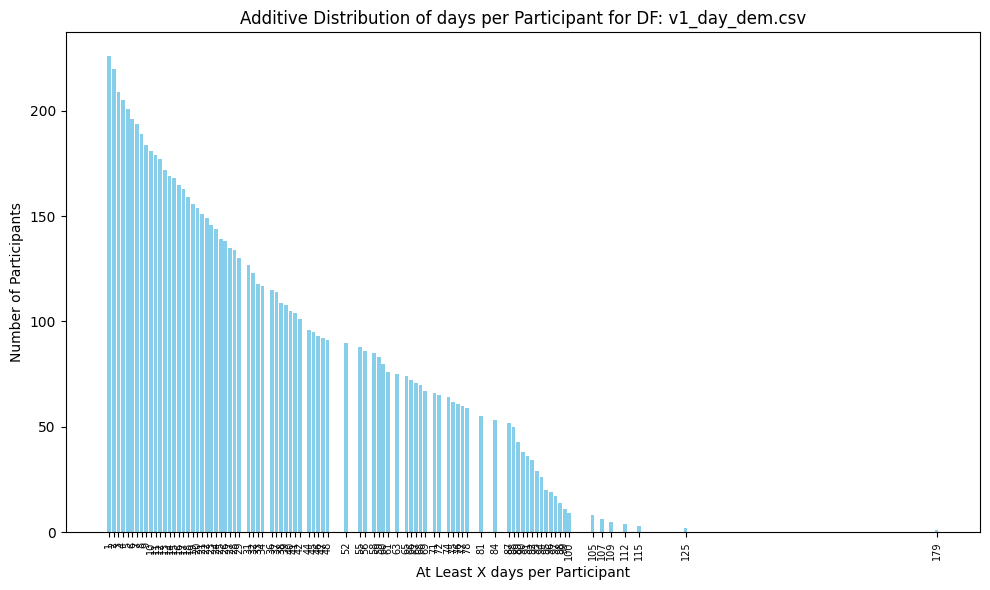

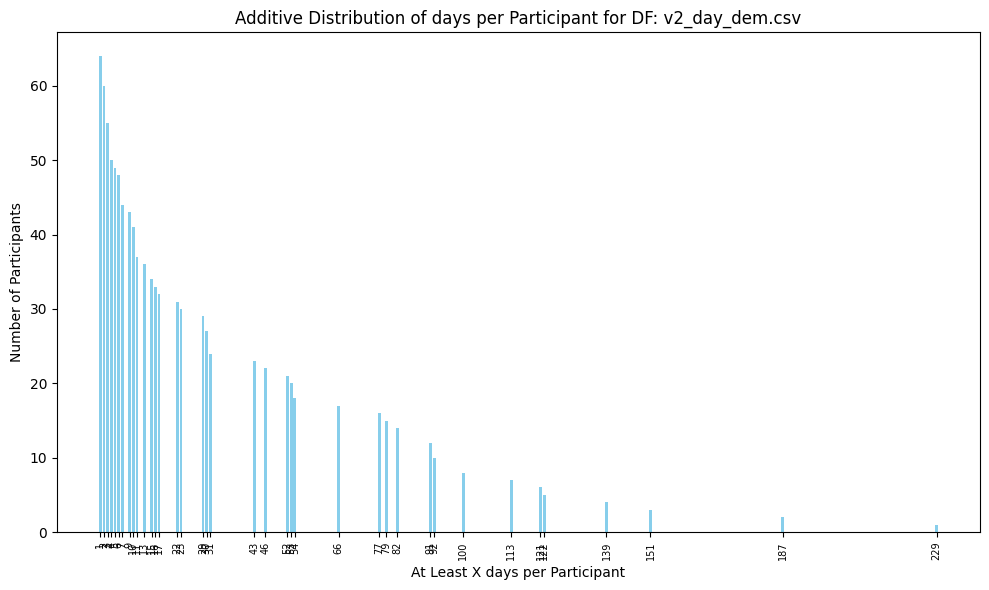

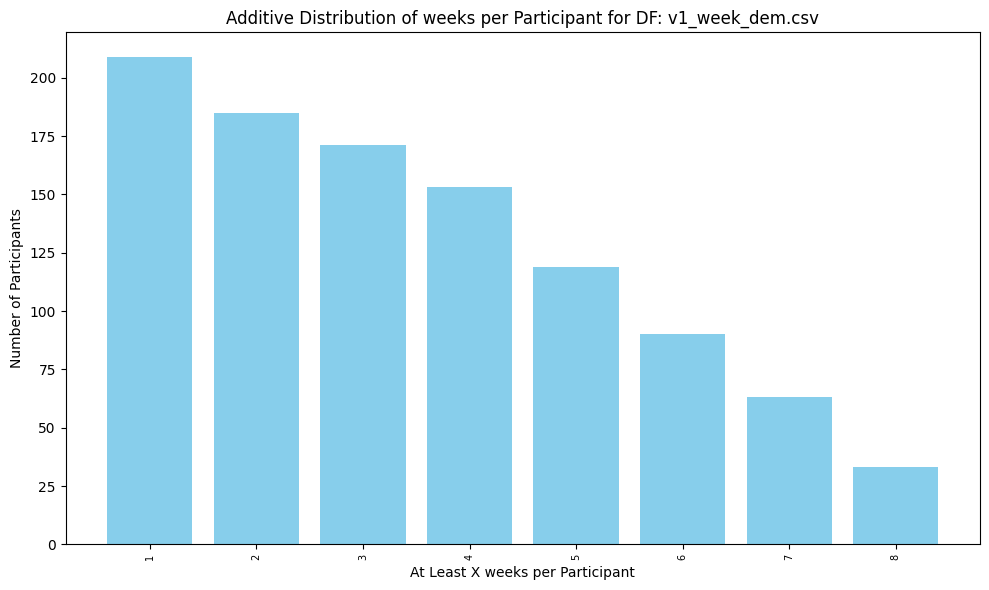

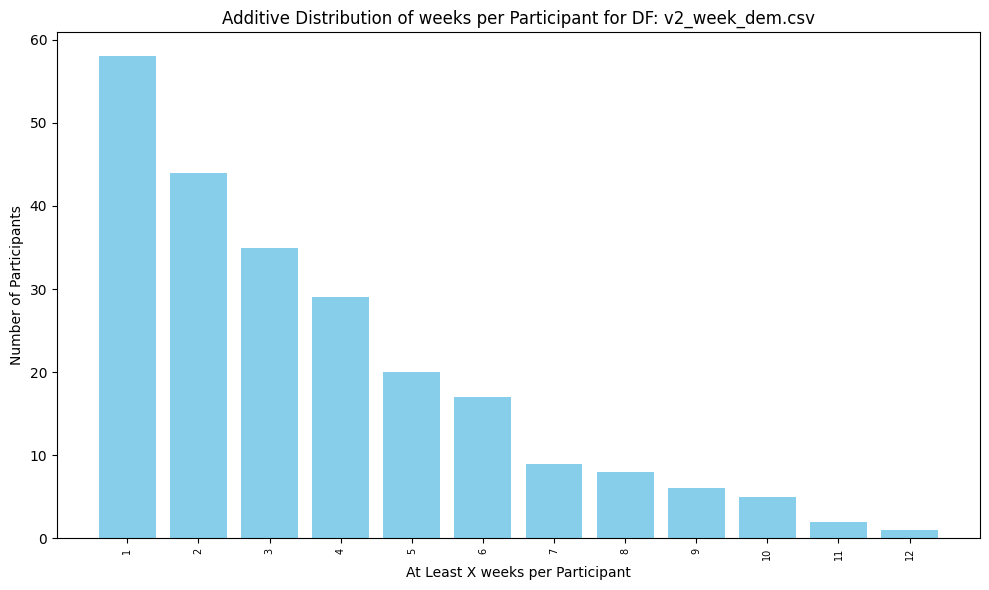

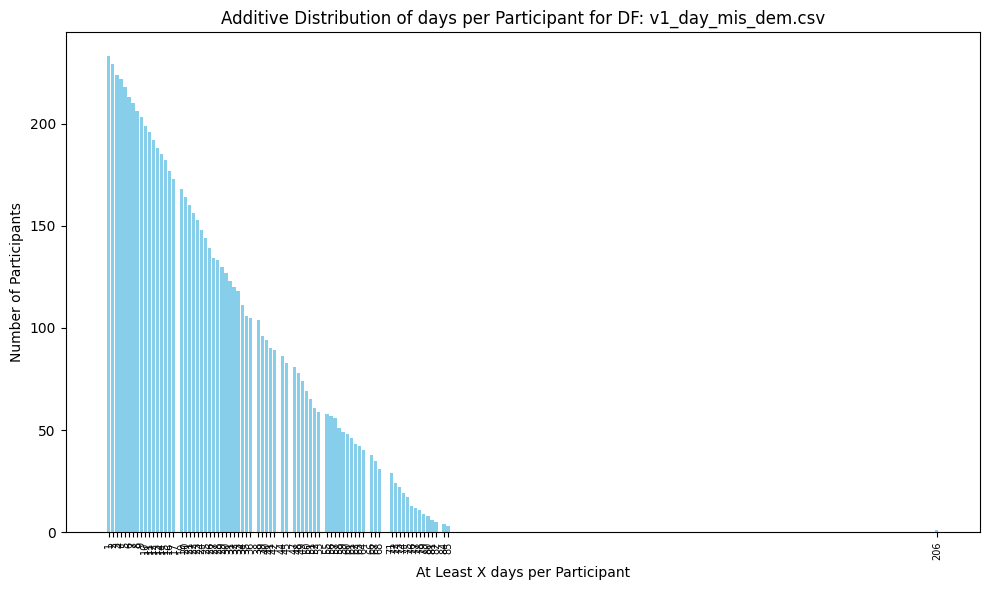

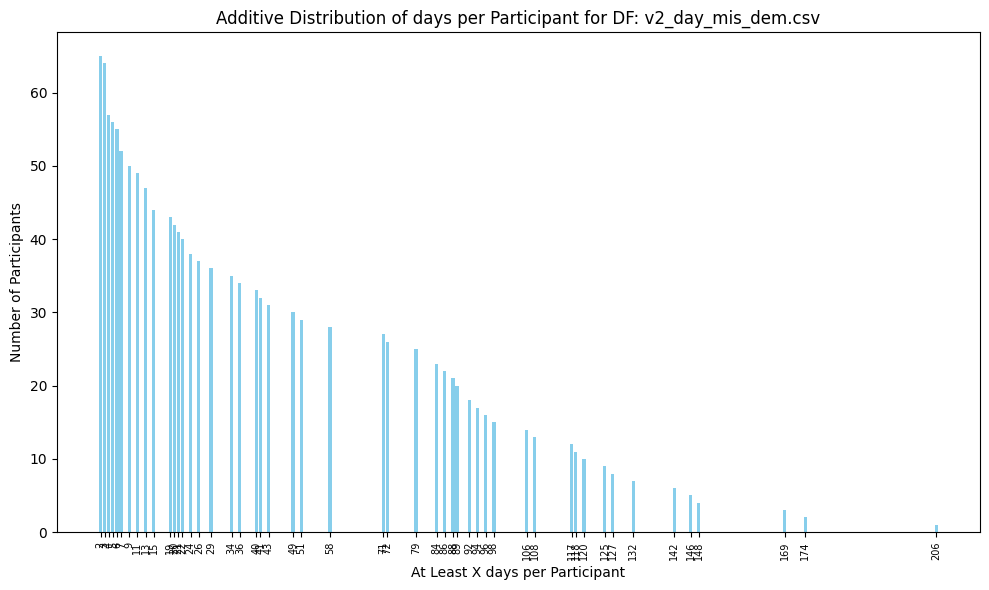

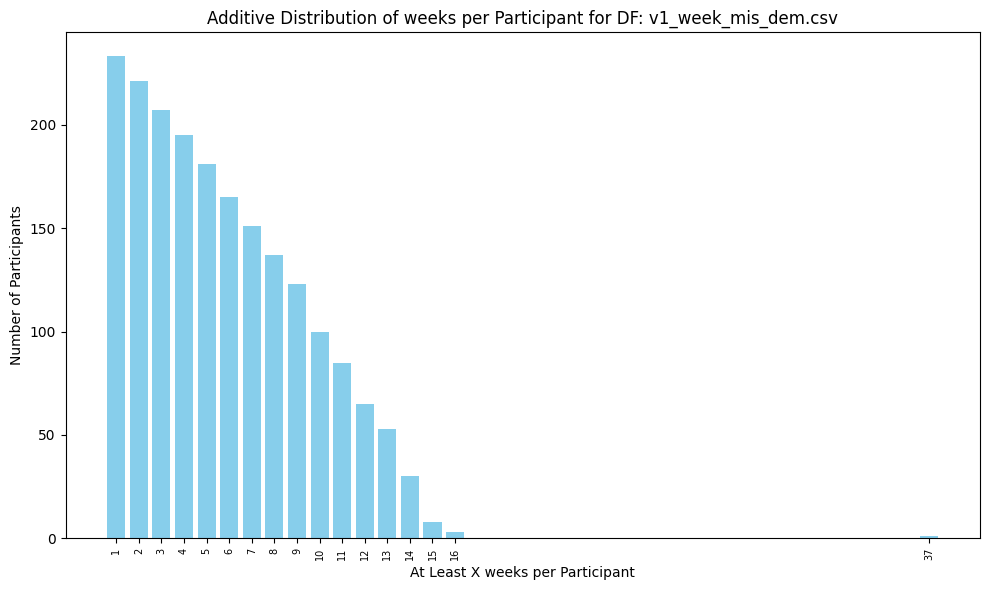

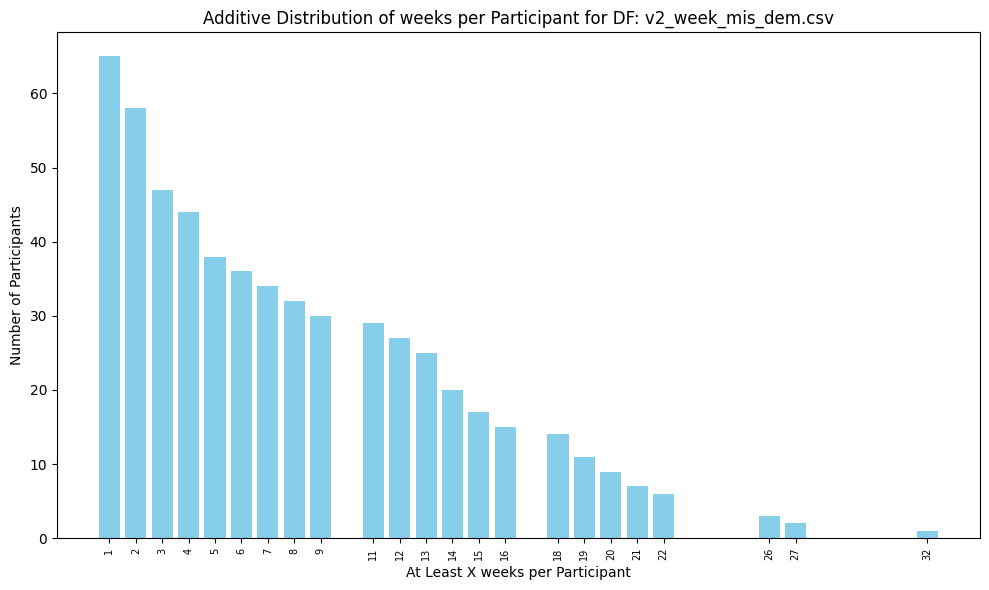

In [27]:
############## Plot-- how many weeks/days does each participant have #############
for name in df_names_with_mis:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_dem.csv'))
    if 'day' in name:
        time_period='day'
    elif 'week' in name:
         time_period='week'

    vis.plot_participants_per_time(df, time_period=time_period, title=f'{name}_dem.csv')


In [ ]:
# Regress out covariates

# Define covariates
demographic_vars = ['gender','age']                # covariates
id_columns = ['num_id','dt','week','day']                              # vv define to_modify as all the other columns to do regression on

# Subset datasets
for name in df_names_with_mis:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_dem.csv'))
    df = pre.regress_covariates(df, to_regress_out=demographic_vars, to_ignore=id_columns)
    df.to_csv(os.path.join(brighten_dir, f'{name}_res.csv'), index=False)
    print(f'Saved df name:{name} to {name}_res.csv')


Saved df name:v1_day to v1_day_res.csv
Saved df name:v2_day to v2_day_res.csv
Saved df name:v1_week to v1_week_res.csv
Saved df name:v2_week to v2_week_res.csv
Saved df name:v1_day_mis to v1_day_mis_res.csv
Saved df name:v2_day_mis to v2_day_mis_res.csv
Saved df name:v1_week_mis to v1_week_mis_res.csv
Saved df name:v2_week_mis to v2_week_mis_res.csv


In [29]:
# ### Drop demographic columns from the dfs
# for name, df in dfs_residuals.items():
#     df = df.drop(columns=demographic_columns, axis=1)
#     df.to_csv(os.path.join(brighten_dir, f'{name}_res_dropped.csv'), index=False)
#     print(f'Saved {name}_res_dropped.csv')


This is the raw data


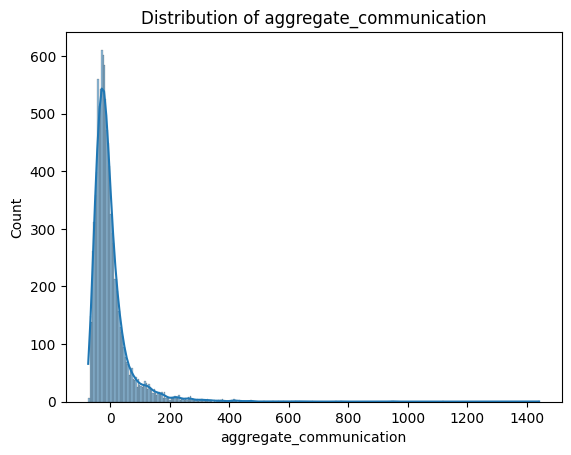

This is the lesioned data- it should have less outliers


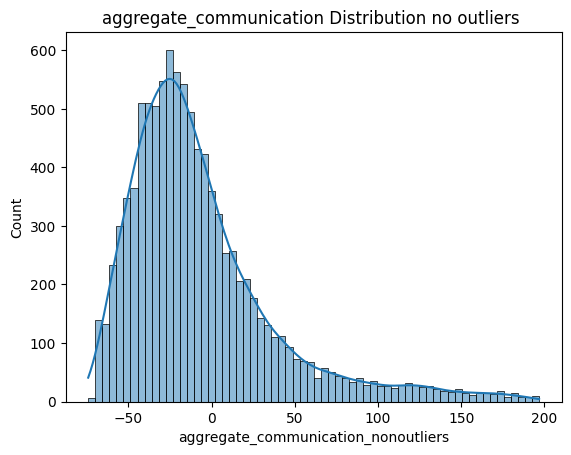

Scaled data for same subject in  original dataframe-- should look exaclty like above with different scale


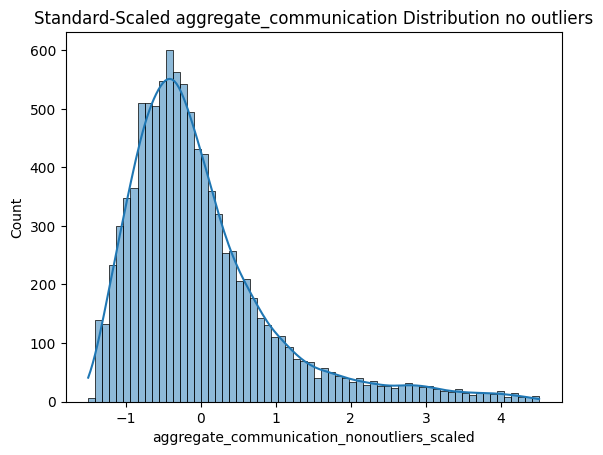

More lesioned data but in new  dataframe-- should look exactly like above


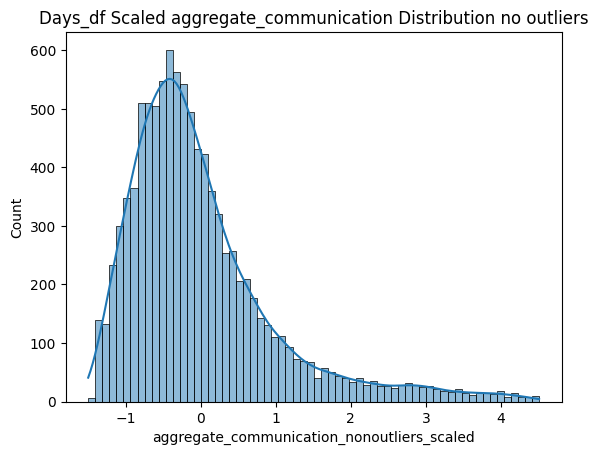

In [30]:
### Plot scaling and removal of outliers 
v1_day_res = pd.read_csv(os.path.join(brighten_dir, f'v1_day_res.csv'))

pre.plot_normalization(v1_day_res, daily_cols_v1 + phq2_cols, num_to_plot=1, subject_to_plot=None)


In [ ]:
### If chart tests above go through, run this:

##### Scale and drop outliers ######
to_regress_out = ['gender','education','race','age']                # covariates
to_ignore = ['num_id','dt','week','day']  

# Scale and remove outliers for subset DFs
dfs_scaled = {}
for name in df_names_with_mis:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_res.csv'))
    cols_to_scale = [col for col in df.columns.to_list() if (col not in to_regress_out) and (col not in to_ignore)]
    dfs_scaled[name] = pre.normalize_df(df, cols_to_scale)
    dfs_scaled[name].to_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'), index=False)
    print(f'Saved dfs_scaled[{name}] to {name}_scaled.csv')

# # Scale and remove outliers for week and day dfs, even though they're not residualized
df_alldays_int70 = pd.read_csv(os.path.join(brighten_dir, 'df_alldays_int70.csv'))
scaled_df_alldays_int70 = pre.normalize_df(df_alldays_int70, daily_cols_v1 + phq2_cols + daily_v2_common + phq9_cols)
scaled_df_alldays_int70.to_csv(os.path.join(brighten_dir, 'scaled_df_alldays_int70.csv'), index=False)

week_df_int70 = pd.read_csv(os.path.join(brighten_dir, 'week_df_int70.csv'))
scaled_df_week_int70 = pre.normalize_df(week_df_int70, daily_cols_v1 + phq2_cols + daily_v2_common + phq9_cols)
scaled_df_week_int70.to_csv(os.path.join(brighten_dir, 'scaled_df_week_int70.csv'), index=False)





Saved dfs_scaled[v1_day] to v1_day_scaled.csv
Saved dfs_scaled[v2_day] to v2_day_scaled.csv
Saved dfs_scaled[v1_week] to v1_week_scaled.csv
Saved dfs_scaled[v2_week] to v2_week_scaled.csv
Saved dfs_scaled[v1_day_mis] to v1_day_mis_scaled.csv
Saved dfs_scaled[v2_day_mis] to v2_day_mis_scaled.csv
Saved dfs_scaled[v1_week_mis] to v1_week_mis_scaled.csv
Saved dfs_scaled[v2_week_mis] to v2_week_mis_scaled.csv


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_5534/4252165899.py:17: DtypeWarning: Columns (14,23,48,106,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_alldays_int70 = pd.read_csv(os.path.join(brighten_dir, 'df_alldays_int70.csv'))
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_5534/4252165899.py:21: DtypeWarning: Columns (24,107,108,109) have mixed types. Specify dtype option on import or set low_memory=False.
  week_df_int70 = pd.read_csv(os.path.join(brighten_dir, 'week_df_int70.csv'))


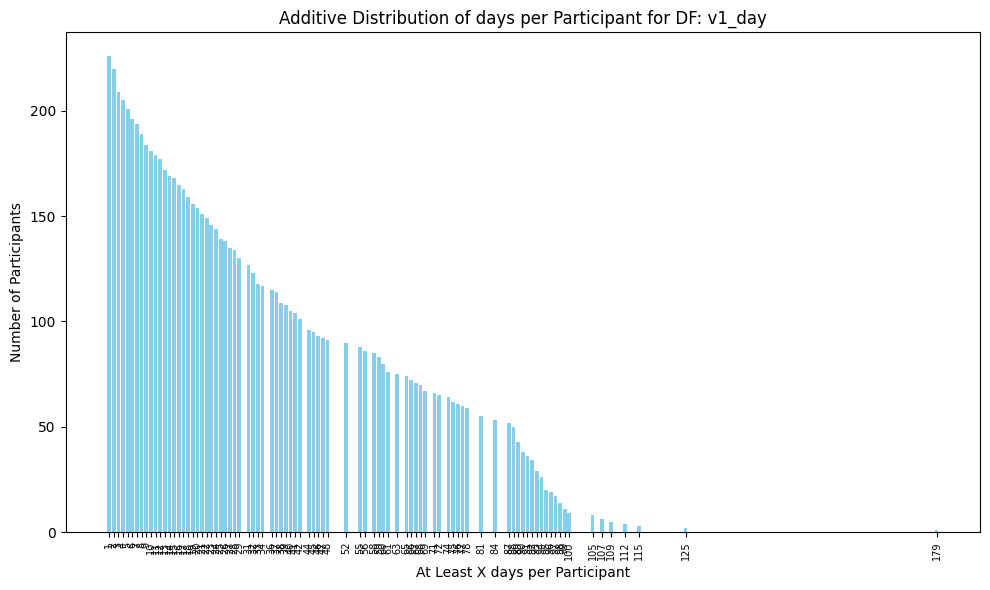

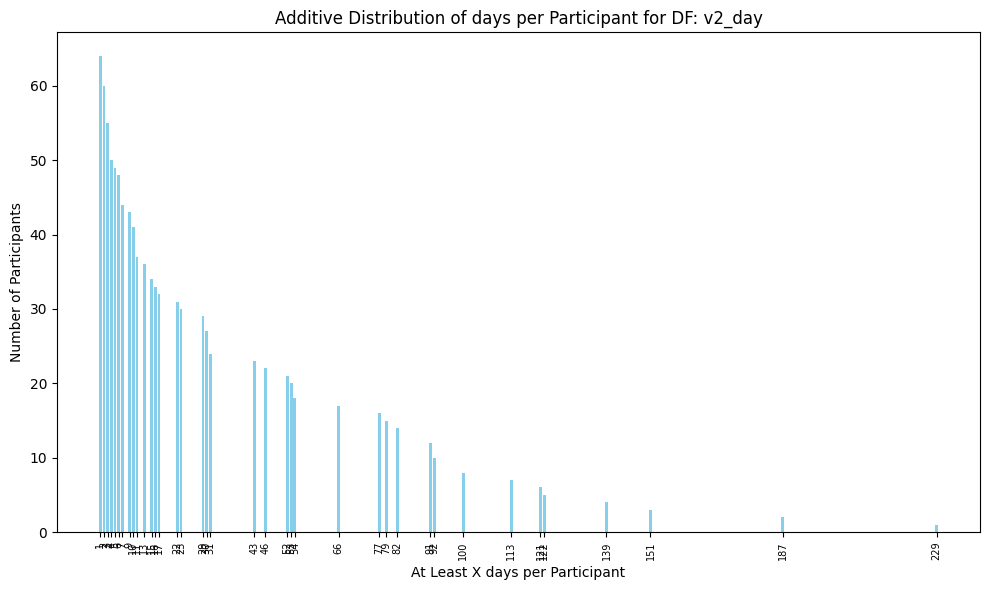

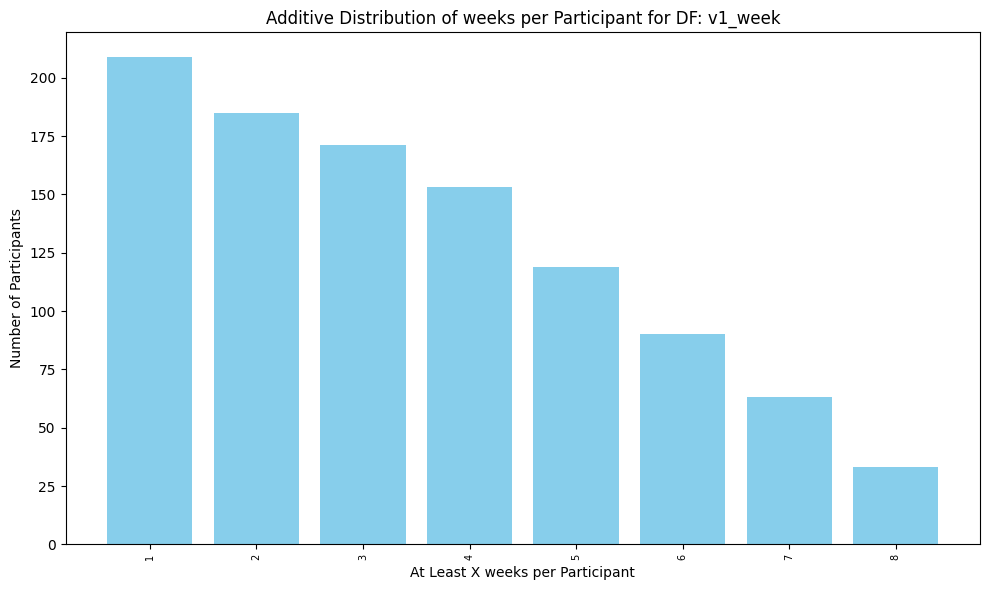

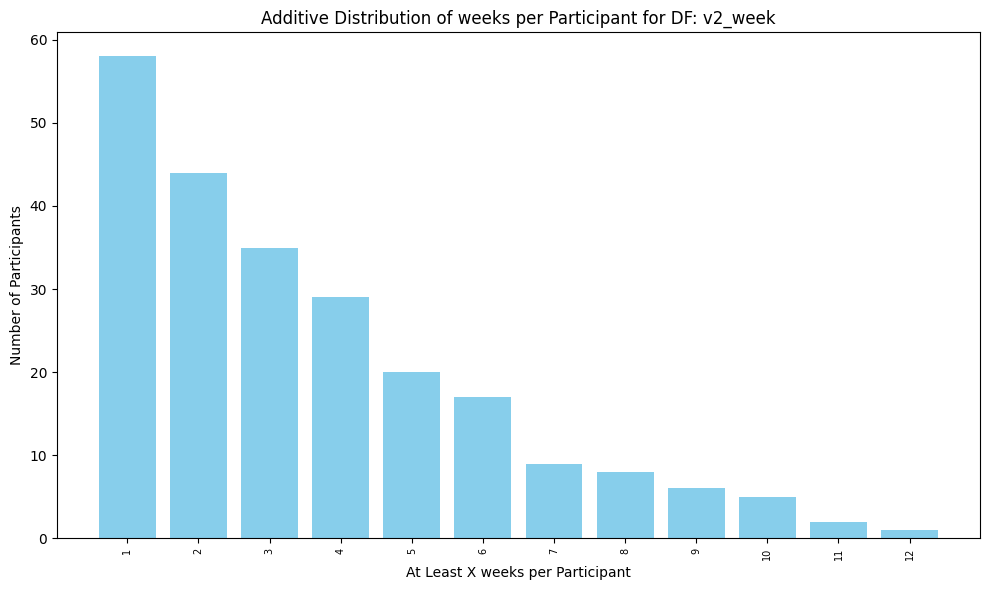

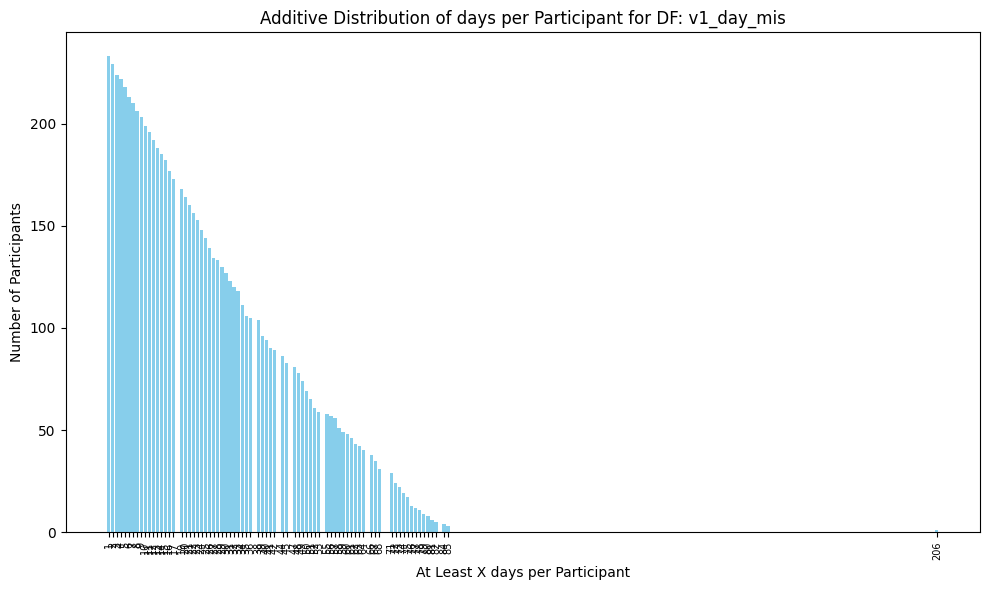

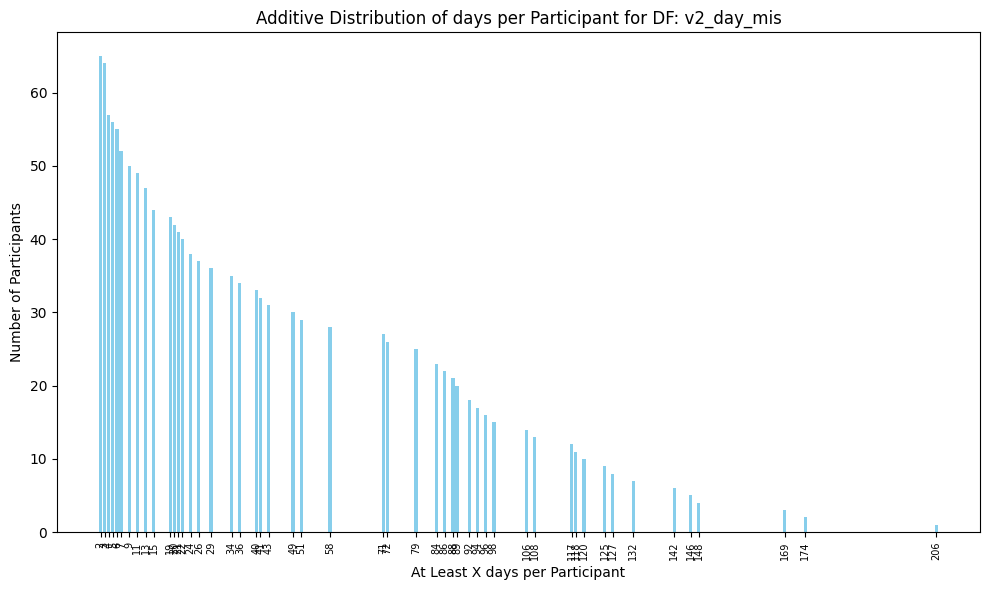

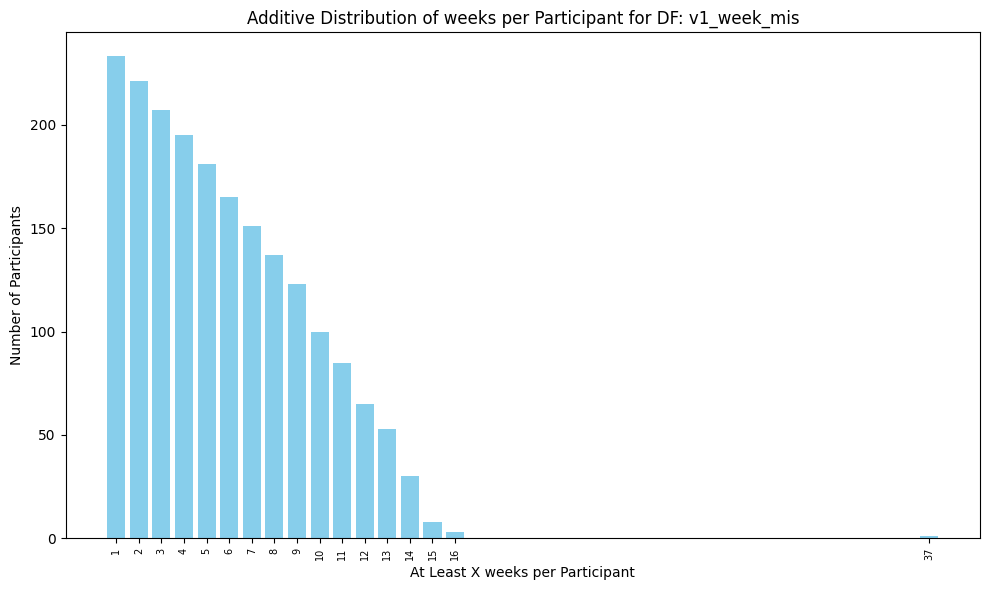

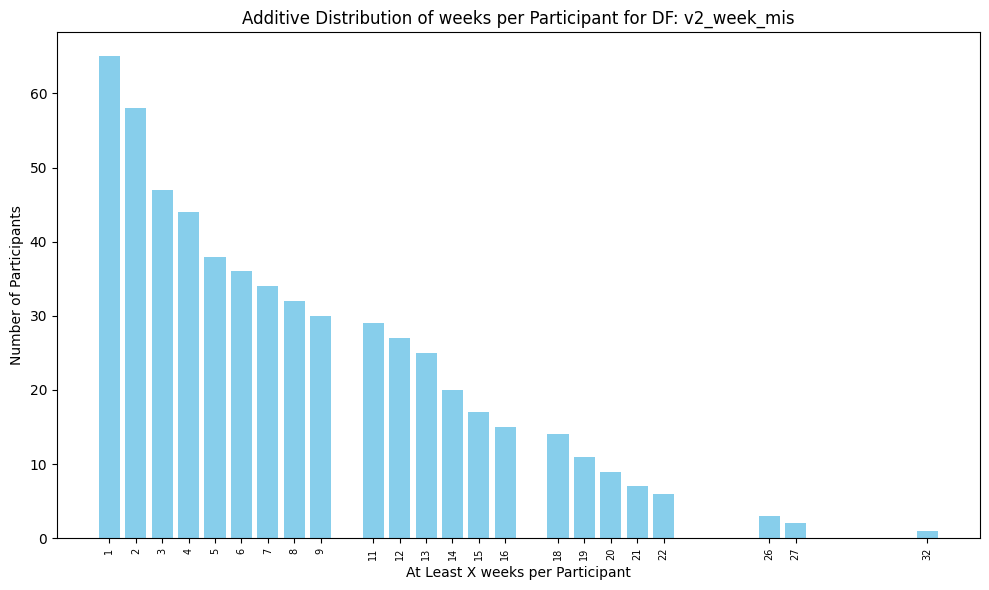

In [32]:
############## Plot-- how many weeks/days does each participant have #############
for name in df_names_with_mis:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))
    if 'day' in name:
        vis.plot_participants_per_time(df, time_period='day', title=name)
    elif 'week' in name:
        vis.plot_participants_per_time(df, time_period='week', title=name)



In [33]:
### Create lag variable
for name in df_names_with_mis:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))
    print(f'\n\nFor {name}:')
    if 'week' in name:
        df_lag = pre.create_lag_variables(df, phq9_cols + phq2_cols)
    if 'day' in name:
        df_lag = pre.create_lag_variables(df, phq2_cols)
    
    df_lag.to_csv(os.path.join(brighten_dir, f'{name}_lag.csv'), index=False)
    




For v1_day:

 Adding lag of -1 to column: phq2_1 -> phq2_1_lag-1
col df shape is: (10226, 3)

 Adding lag of -1 to column: phq2_2 -> phq2_2_lag-1
col df shape is: (10226, 3)

 Adding lag of -1 to column: phq2_sum -> phq2_sum_lag-1
col df shape is: (10226, 3)


For v2_day:

 Adding lag of -1 to column: phq2_1 -> phq2_1_lag-1
col df shape is: (2651, 3)

 Adding lag of -1 to column: phq2_2 -> phq2_2_lag-1
col df shape is: (2651, 3)

 Adding lag of -1 to column: phq2_sum -> phq2_sum_lag-1
col df shape is: (2651, 3)


For v1_week:

 Adding lag of -1 to column: phq9_1 -> phq9_1_lag-1
col df shape is: (1023, 3)

 Adding lag of -1 to column: phq9_2 -> phq9_2_lag-1
col df shape is: (1023, 3)

 Adding lag of -1 to column: phq9_3 -> phq9_3_lag-1
col df shape is: (1023, 3)

 Adding lag of -1 to column: phq9_4 -> phq9_4_lag-1
col df shape is: (1023, 3)

 Adding lag of -1 to column: phq9_5 -> phq9_5_lag-1
col df shape is: (1023, 3)

 Adding lag of -1 to column: phq9_6 -> phq9_6_lag-1
col df shape 